# Titanic
Work on the [Titanic](https://www.kaggle.com/c/titanic) kaggle competition.

## Overall idea
Build several logistic regression modelto classify people based on their features. I'll start from a very basic one, i.e. logistic regression with just the available features and add more complexity step by step on both feature handling (e.g. feature normalisation, etc.) and the model itself (e.g. more features, more complex models).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import utils
import socket

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score

from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

% matplotlib inline

## Load the data
Load the data and do some very preliminary exploration.

In [2]:
data_path = utils.getDataPath()

In [3]:
df_train = pd.read_csv('{}/train.csv'.format(data_path), skipinitialspace=True)

In [4]:
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

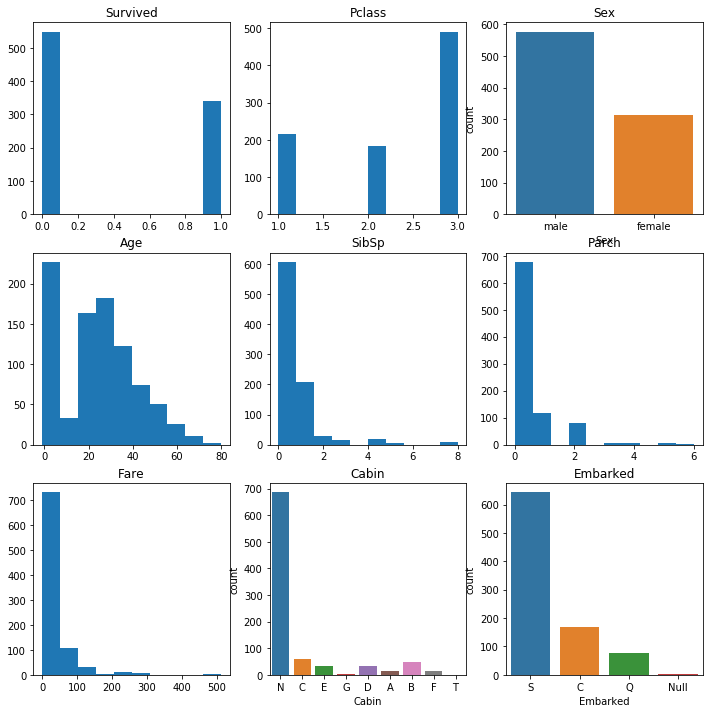

In [6]:
# plot all "plottable" variables
vars = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

fig, axes = plt.subplots(3, 3, figsize=(12,12))
for i in range(3):
    for j in range(3):
        idx = 3*i + j
        var = vars[idx]
        axes[i,j].set_title(var)
        if is_string_dtype(df_train[var]):
            df_tmp = df_train[var].fillna('Null')
            if var == 'Cabin':
                df_tmp = df_train[var].fillna('Null').str[0]
            sb.countplot(x=df_tmp, ax=axes[i,j])
        else:
            df_tmp = df_train[var].fillna(-1)
            _ = axes[i,j].hist(df_tmp)
        

### Comments on raw vars
`Age` can be `null`, and this happens ha sizeable amount of times (177 times out of 891). At a first look this doesn't seem to be (strongly) correlated to any of the other features.

Third class (`Pclass` = 3) people are not assigned any cabin (`Cabin` = Nan).

### Relations between variables
Try to study the relations between some variables.

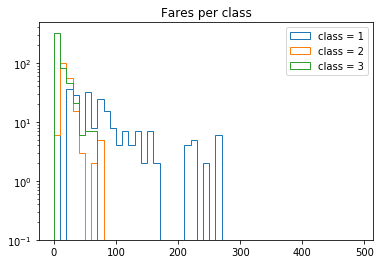

In [7]:
plt.figure()
plt.title('Fares per class')
for c in np.sort(df_train.Pclass.unique()):
    _ = plt.hist(df_train[ df_train.Pclass==c ].Fare, bins=range(0,500,10), histtype='step', label='class = {}'.format(c), log=True)
plt.legend(loc='best')

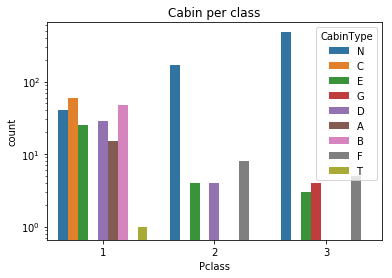

In [8]:
df_tmp = df_train.assign(CabinType = lambda x : x.Cabin.fillna('Null').str[0])

plt.figure()
plt.title('Cabin per class')
sb.countplot(x='Pclass', data=df_tmp, hue='CabinType', log=True)

What is written above is not entirely true: cabins are available for all classes, but they have some kind of distribution. The majority of 3rd class people do not have a cabin, but also some second and first class people do not have a cabin. G cabins seem to be reseved to 3rd class people, while some other types are reserved to second and first class people. The only kind of cabins available for all the three classes are E cabins.

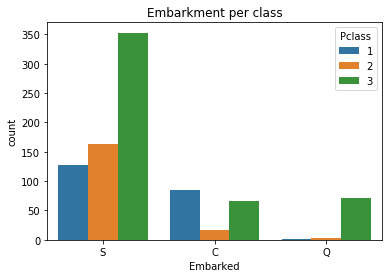

In [9]:
plt.figure()
plt.title('Embarkment per class')
sb.countplot(x='Embarked', data=df_train, hue='Pclass', log=False)

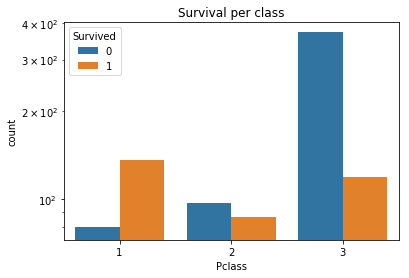

In [10]:
plt.figure()
plt.title('Survival per class')
sb.countplot(x='Pclass', data=df_train, hue='Survived', log=True)

## Playing with the models
In this section the models are built and fitted.

### v_00: no engineering
In this version I just use the input features as they are. Neverthelsess some data preprocessing is anyway needed:
* replace `NaN`s with a fixed value
* replace `str` value with numeric values (doing the most basic thing)

In [11]:
# interesting features (discarding 'Ticket' for now)
feat_list = ['Pclass','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
input_feat_list = feat_list.copy()

In [12]:
# take care of categorical features
for entry in feat_list:
    if is_string_dtype(df_train[entry]): print(entry)

Sex
Cabin
Embarked


In [13]:
# sex: male = 0 / female = 1
df_train = df_train.assign(Sex_cat = 0)
df_train.loc[ df_train['Sex']=='female', 'Sex_cat' ] = 1
input_feat_list = utils.replaceElementInList('Sex', 'Sex_cat', input_feat_list)

In [14]:
# cabin: take the first char, then map to ints
cabin_to_int_dict = {}
idx = 0
for entry in df_train.Cabin.fillna('Null').str[0].unique():
    cabin_to_int_dict[entry] = idx
    idx += 1
df_train = df_train.assign(Cabin_cat = lambda x : x.Cabin.fillna('Null').str[0].map(cabin_to_int_dict))
#embark_to_int_dict
input_feat_list = utils.replaceElementInList('Cabin', 'Cabin_cat', input_feat_list)

In [15]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Cabin_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0


In [16]:
# embarked: map to ints
embarked_to_int_dict = {}
idx = 0
for entry in df_train.Embarked.fillna('Null').unique():
    embarked_to_int_dict[entry] = idx
    idx += 1
df_train = df_train.assign(Embarked_cat = lambda x : x.Embarked.map(embarked_to_int_dict))
#embarked_to_int_dict
input_feat_list = utils.replaceElementInList('Embarked', 'Embarked_cat', input_feat_list)

In [17]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_cat,Cabin_cat,Embarked_cat
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,1,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,1,0.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0.0


In [18]:
# replace NaNs with -1
for c in df_train.columns:
    if not is_string_dtype(df_train[c]):
        df_train[c] = df_train[c].fillna(-1)

In [19]:
# split the features from the target
x_train = df_train[input_feat_list].values
y_train = df_train['Survived'].values

Now build the model.

In [20]:
m_00 = LogisticRegression()

In [21]:
m_00.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [22]:
y_train_pred_00 = m_00.predict(x_train)

## Evaluation

In [23]:
fpr_00, tpr_00, thr_00 = roc_curve(y_train, y_train_pred_00)
score_00 = roc_auc_score(y_train, y_train_pred_00)

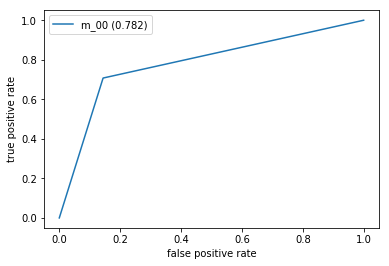

In [24]:
plt.figure()
plt.plot(fpr_00, tpr_00, label='m_00 ({:.3})'.format(score_00))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc='best')